In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [80]:
file_to_load = "./DATA/2019-Oct.csv"

chunksize = 50_000
fraction = 0.01
seed = 42

In [81]:
chunks = pd.read_csv(file_to_load, chunksize=chunksize)

In [82]:
def getRandomDataset(chunks, frac, seed):
    return pd.concat(chunk.sample(frac=frac, random_state=seed) for chunk in chunks)

In [83]:
df = getRandomDataset(chunks, fraction, seed)

In [84]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
33553,2019-10-01 03:12:25 UTC,view,13200276,2053013557192163841,furniture.bedroom.bed,brw,130.76,529306458,cab02446-c43b-4d57-ab7c-e0c850de22a6
9427,2019-10-01 02:36:19 UTC,view,23000277,2164367422893589471,NaN,mitasu,20.59,516640053,ce9d2b9e-bbf4-42bb-9034-f7b6ad36013e
199,2019-10-01 00:02:46 UTC,view,3200321,2053013555321504139,appliances.kitchen.meat_grinder,redmond,91.38,515744951,d35a2b1e-a781-45c4-a4f1-7e851d2a4c16
12447,2019-10-01 02:41:29 UTC,view,9000121,2053013566067311601,NaN,janome,216.53,517859956,73641920-7de0-4a1b-89dd-75fb7a13d084
39489,2019-10-01 03:19:56 UTC,view,21403078,2053013561579406073,electronics.clocks,casio,39.05,512904025,d5e9ab30-2685-42cb-b4db-5a2d5ad4fd84


In [85]:
df.describe()

,product_id,category_id,price,user_id
count,4.244880e+05,4.244880e+05,424488.000000,4.244880e+05
mean,1.055876e+07,2.057400e+18,289.422948,5.335261e+08
std,1.188062e+07,1.842630e+16,357.543821,1.852428e+07
min,1.000978e+06,2.053014e+18,0.000000,2.050532e+08
25%,1.005158e+06,2.053014e+18,65.640000,5.159180e+08
50%,5.000568e+06,2.053014e+18,161.910000,5.296808e+08
75%,1.600055e+07,2.053014e+18,358.440000,5.515535e+08
max,6.050000e+07,2.175420e+18,2574.070000,5.662785e+08


In [86]:
def createNaAndUniqueMatrix(df):
    rows = ["Valeurs nulles", "Valeurs uniques"]

    data = {}

    for column in df.columns:    
        na = df[column].isna()
        unique = len(df[column][~na].unique())

        data[column] = [f'{len(df[na])} ({(len(df[na])/len(df))*100:.2f}%)', unique]

    return pd.DataFrame(data, index=rows)

In [87]:
createNaAndUniqueMatrix(df)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
Valeurs nulles,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),135187 (31.85%),61277 (14.44%),0 (0.00%),0 (0.00%),0 (0.00%)
Valeurs uniques,383432,3,59203,597,126,2428,28792,320848,399005


Analysons les 3 valeurs uniques d'event_type

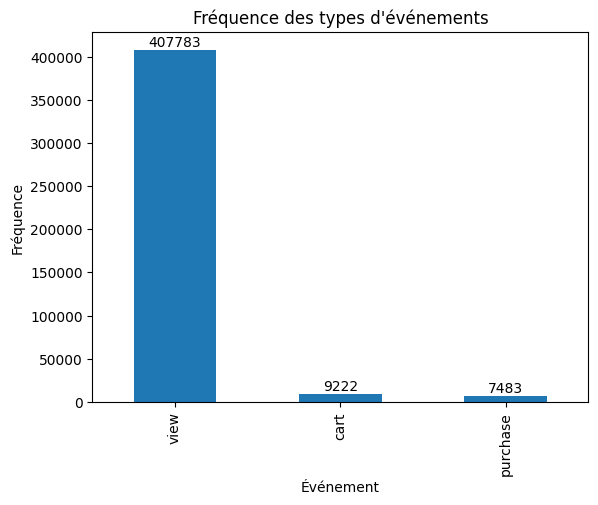

In [88]:
frequences = df["event_type"][df["event_type"].notna()].value_counts()

ax = frequences.plot(kind="bar")

for i,v in enumerate(frequences):
    ax.text(i, v + 0.1, str(v), ha="center", va="bottom")

plt.title("Fréquence des types d'événements")
plt.xlabel("Événement")
plt.ylabel("Fréquence")
plt.show()

On recense donc 407 757 vues, 9237 mises dans un panier et 7494 achats

Quels sont les taux de conversion entre les types d'événements ?

In [89]:
viewToCart = frequences["cart"] / frequences["view"] * 100
cartToPurchase = frequences["purchase"] / frequences["cart"] * 100
viewToPurchase = frequences["purchase"] / frequences["view"] * 100

print(f"Taux de conversion vue => panier : {viewToCart:.2f} %")
print(f"Taux de conversion panier => achat : {cartToPurchase:.2f} %")
print(f"Taux de conversion vue => achat : {viewToPurchase:.2f} %")

Taux de conversion vue => panier : 2.26 %
Taux de conversion panier => achat : 81.14 %
Taux de conversion vue => achat : 1.84 %


Combien d'utilisateurs différents ont fait un achat ?

In [90]:
usersPurchased = len(df["user_id"][df["event_type"] == "purchase"].unique())

itemsPurchasedPerUser = frequences["purchase"] / usersPurchased

maxUserBuy = df[df["event_type"] == "purchase"].groupby("user_id").size().max()
maxSessionBuy = df[df["event_type"] == "purchase"].groupby("user_session").size().max()

print(f"Un total de {usersPurchased} utilisateurs différents ont effectué des achats sur le site")
print(f"Un utilisateur qui achète sur le site achète en moyenne {itemsPurchasedPerUser:.2f} articles")
print(f"L'utilisateur qui a le plus acheté a acheté {maxUserBuy} articles sur le mois")
print(f"La session utilisateur qui a le plus acheté a acheté {maxSessionBuy} articles en une session")

Un total de 7241 utilisateurs différents ont effectué des achats sur le site
Un utilisateur qui achète sur le site achète en moyenne 1.03 articles
L'utilisateur qui a le plus acheté a acheté 4 articles sur le mois
La session utilisateur qui a le plus acheté a acheté 2 articles en une session


Comment évoluent les achats sur le mois ?

In [91]:
datesDayToDay = pd.to_datetime(df["event_time"]).dt.date
purchasesDayToDay = df[df["event_type"] == "purchase"].groupby(datesDayToDay)["event_type"].count()
uniqueDates = datesDayToDay.unique()

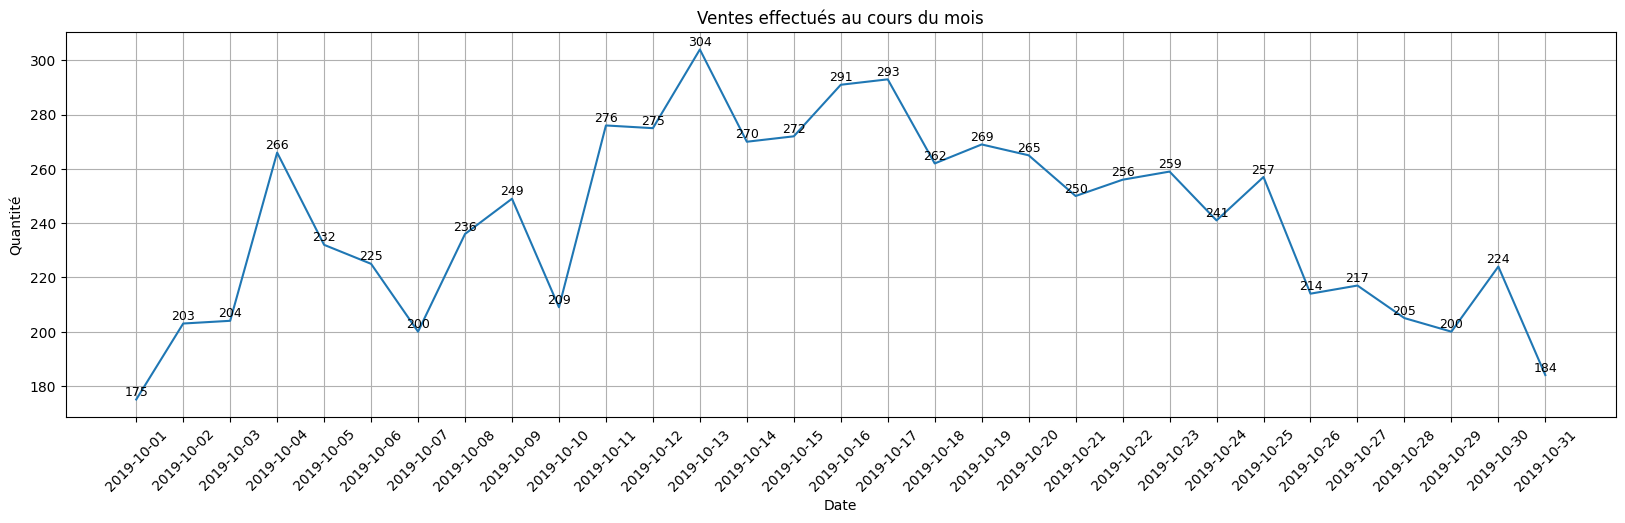

In [92]:
plt.figure(figsize=(20, 5))
plt.plot(uniqueDates, purchasesDayToDay)

for x,y in zip(uniqueDates, purchasesDayToDay):
    plt.text(x, y + 0.3, y, ha="center", va="bottom", fontsize=9)

plt.title("Ventes effectués au cours du mois")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.grid(True)
plt.xticks(uniqueDates, rotation=45)

plt.show()

Quel est le chiffre d'affaire quotidien ?

In [93]:
datesDayToDay = pd.to_datetime(df["event_time"]).dt.date
gainsDayToDay = df[df["event_type"] == "purchase"].groupby(datesDayToDay)["price"].sum()
uniqueDates = datesDayToDay.unique()

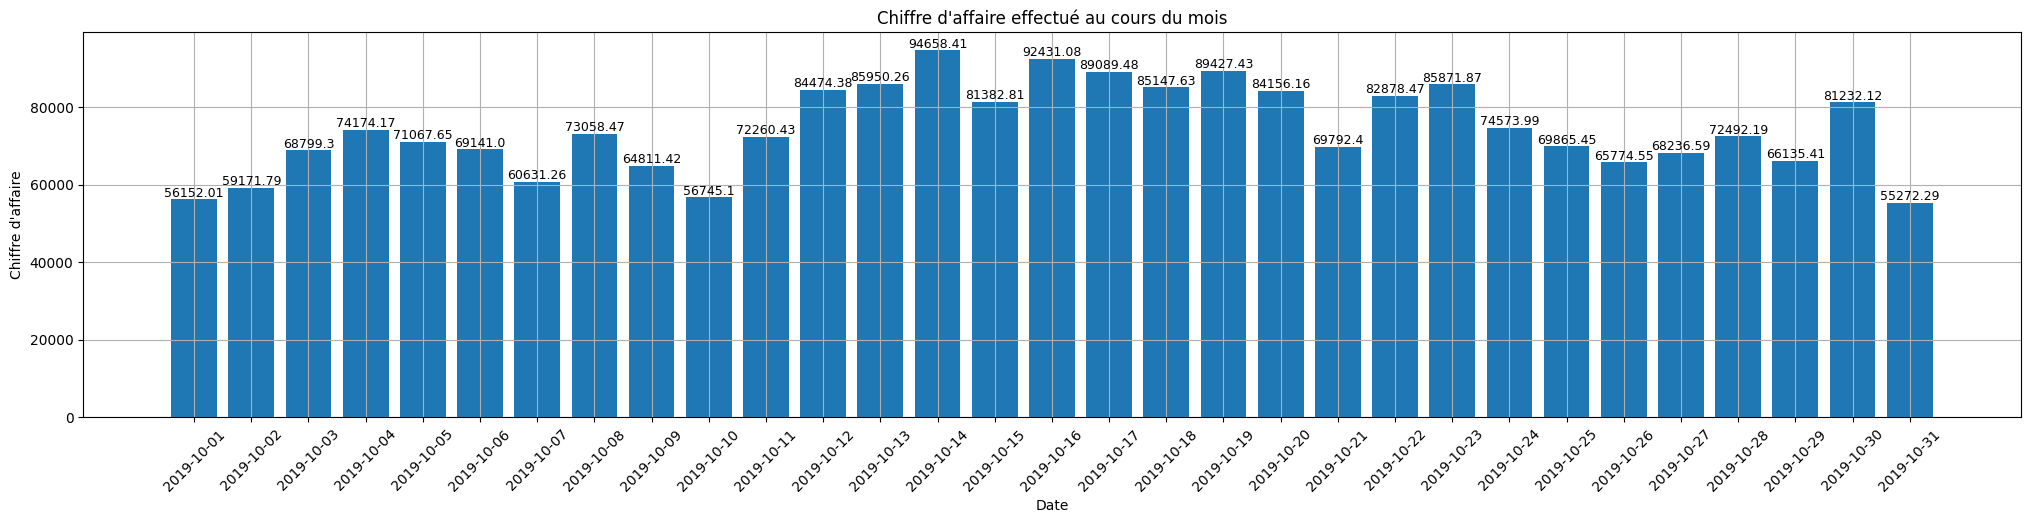

In [94]:
plt.figure(figsize=(25, 5))
plt.bar(uniqueDates, gainsDayToDay)

for x,y in zip(uniqueDates, gainsDayToDay):
    plt.text(x, y + 0.3, y, ha="center", va="bottom", fontsize=9)

plt.title("Chiffre d'affaire effectué au cours du mois")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.grid(True)
plt.xticks(uniqueDates, rotation=45)

plt.show()

In [95]:
df = pd.get_dummies(df, columns=["event_type"])

In [98]:
encoder = OneHotEncoder(sparse_output=False)

In [ ]:
df["category_id"] = encoder.fit_transform(df[["category_id"]])

MemoryError: Unable to allocate 1015. GiB for an array with shape (424488, 320848) and data type float64

In [96]:
df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view
33553,2019-10-01 03:12:25 UTC,13200276,2053013557192163841,furniture.bedroom.bed,brw,130.76,529306458,cab02446-c43b-4d57-ab7c-e0c850de22a6,False,False,True
9427,2019-10-01 02:36:19 UTC,23000277,2164367422893589471,NaN,mitasu,20.59,516640053,ce9d2b9e-bbf4-42bb-9034-f7b6ad36013e,False,False,True
199,2019-10-01 00:02:46 UTC,3200321,2053013555321504139,appliances.kitchen.meat_grinder,redmond,91.38,515744951,d35a2b1e-a781-45c4-a4f1-7e851d2a4c16,False,False,True
12447,2019-10-01 02:41:29 UTC,9000121,2053013566067311601,NaN,janome,216.53,517859956,73641920-7de0-4a1b-89dd-75fb7a13d084,False,False,True
39489,2019-10-01 03:19:56 UTC,21403078,2053013561579406073,electronics.clocks,casio,39.05,512904025,d5e9ab30-2685-42cb-b4db-5a2d5ad4fd84,False,False,True


Cherchons maintenant les corrélations entre les différentes features

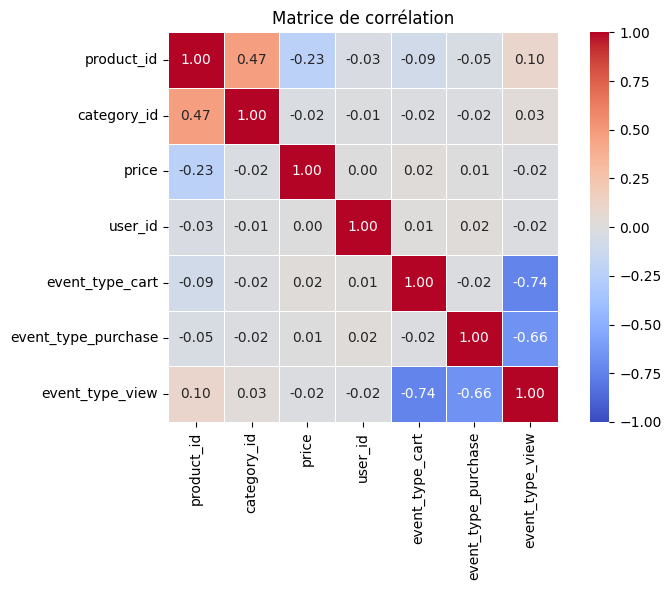

In [97]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()